# Sales prediction project
The aim is to forecast store sales for many products on data from Corporación Favorita, a large Ecuadorian-based grocery retailer.

# 1. Problem definition
This will be a time series regression problem, since a number needs to be predicted and a time period is given.

# 2. General information on the data
The dataset is composed of various smaller datasets: train.csv, test.csv, holidays-events.csv, oil.csv, stores.csv and transactions.csv, and it is taken from Kaggle: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data.

Now for a description of the smaller datasets:

train.csv - training data, is composed of the time series features store_nbr (store where products are sold), family (type of product sold), onpromotion (total number of items in a product family that were being promoted at a store at a given date) and sales(total sales for a product family at a particular store at a given date).

test.csv - test data, has the same features as train.csv

stores.csv - store metadata

oil.csv - daily oil price (affects the economy a lot)

holidays_events.csv - holidays and events metadata

transactions.csv - transactions conducted at a given date and store

# 3. Exploratory Data Analysis (EDA) and Preprocessing

In [1]:
# Importing the necessary tools
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_log_error # The evaluation metric
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import LabelEncoder

In [2]:
# Creating the necessary DataFrames
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
# Exploring the datasets
datasets = {"train":train,
            "test":test}

In [4]:
# Function to analyze datasets
def analyze_data(datasets):
    for name, dataset in datasets.items():
        print(f"Summary for {name} DataFrame:")
        print(dataset.head())
        print(dataset.info())
        print(dataset.describe())
        print(dataset.isna().sum())

analyze_data(datasets)

Summary for train DataFrame:
   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None
                 id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e

Now that that's out of the way, all data needs to be converted into a numeric fashion, starting with the dates.

In [5]:
# Date extraction for the train DataFrame
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train = train.drop(columns=['date'])

# Info on train
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
 5   year         int32  
 6   month        int32  
 7   day          int32  
dtypes: float64(1), int32(3), int64(3), object(1)
memory usage: 148.8+ MB


In [6]:
# Date extraction for the test DataFrame
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test = test.drop(columns=['date'])

# Info on test
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   store_nbr    28512 non-null  int64 
 2   family       28512 non-null  object
 3   onpromotion  28512 non-null  int64 
 4   year         28512 non-null  int32 
 5   month        28512 non-null  int32 
 6   day          28512 non-null  int32 
dtypes: int32(3), int64(3), object(1)
memory usage: 1.2+ MB


Now that all the date values have been splitted into year, month and day, and are in a numeric format, the other object values need to be converted.

In [7]:
# Preprocessing the family column in train
train.family = train.family.astype("category")
encoder = LabelEncoder()
train.family = encoder.fit_transform(train.family)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       int32  
 3   sales        float64
 4   onpromotion  int64  
 5   year         int32  
 6   month        int32  
 7   day          int32  
dtypes: float64(1), int32(4), int64(3)
memory usage: 137.4 MB


In [8]:
# Test preprocessing
test.family = test.family.astype("category")
test.family = encoder.fit_transform(test.family)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   id           28512 non-null  int64
 1   store_nbr    28512 non-null  int64
 2   family       28512 non-null  int32
 3   onpromotion  28512 non-null  int64
 4   year         28512 non-null  int32
 5   month        28512 non-null  int32
 6   day          28512 non-null  int32
dtypes: int32(4), int64(3)
memory usage: 1.1 MB


So, since of all of the data is in an numeric fashion, the next step to build a model.

# 4. Modelling

In [9]:
# Data splitting into training and validation sets
X = train.drop("sales", axis = 1)
y = train.sales

X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [10]:
# Checking shape
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((2400710, 7), (600178, 7), (2400710,), (600178,))

In [11]:
# Function to calculate the root mean squared log error
def rmsle(y_test, y_pred):
    return np.sqrt(mean_squared_log_error(y_test, y_pred))

In [12]:
# Building a model
model = SGDRegressor(max_iter = 1500, early_stopping = True)
model.fit(X_train, y_train)

SGDRegressor(early_stopping=True, max_iter=1500)

In [13]:
# Function for scoring
def score(model):
  train_preds = model.predict(X_train)
  val_preds = model.predict(X_valid)
  train_preds = np.abs(train_preds)
  val_preds = np.abs(val_preds)
  print("Training RMSLE: ", rmsle(y_train, train_preds))
  print("Validation RMSLE: ", rmsle(y_valid, val_preds))

In [14]:
score(model)

Training RMSLE:  43.27863133127154
Validation RMSLE:  43.28098978846873


The training and validation RMSLE are pretty close, so that means that the model is doing a good job.

# 5. Tuning and remodelling
Hyperparameters will be tuned using both RandomizedSearchCV and GridSearchCV, and a new and improved model will be built.

In [15]:
# Parameter grid for SGDRegressor
sgd_grid = {
    "max_iter": np.arange(100, 1001, 100),  # Adjusted range and step size
    "alpha": np.logspace(-6, 0, 100),  # Using a logarithmic scale for alpha
    "l1_ratio": np.arange(0, 1.1, 0.1),  # Adjusted range and step size
    "epsilon": np.arange(0, 0.1, 0.01)  # Adjusted range and step size
}

# Using RandomizedSearchCV
reg = RandomizedSearchCV(model, param_distributions=sgd_grid, n_iter=50, cv=5, verbose=1)
reg.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=SGDRegressor(early_stopping=True, max_iter=1500),
                   n_iter=50,
                   param_distributions={'alpha': array([1.00000000e-06, 1.14975700e-06, 1.32194115e-06, 1.51991108e-06,
       1.74752840e-06, 2.00923300e-06, 2.31012970e-06, 2.65608778e-06,
       3.05385551e-06, 3.51119173e-06, 4.03701726e-06, 4.64158883e-06,
       5.33669923e-06, 6.13590727e-06, 7.05480231e-...
       2.15443469e-01, 2.47707636e-01, 2.84803587e-01, 3.27454916e-01,
       3.76493581e-01, 4.32876128e-01, 4.97702356e-01, 5.72236766e-01,
       6.57933225e-01, 7.56463328e-01, 8.69749003e-01, 1.00000000e+00]),
                                        'epsilon': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                                        'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'max_iter': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
                   verbose=1)

In [16]:
# Checking the best parameters
reg.best_params_

{'max_iter': 1000,
 'l1_ratio': 0.5,
 'epsilon': 0.09,
 'alpha': 0.2848035868435805}

In [17]:
# Retesting
tuned_reg = SGDRegressor(max_iter = 100, l1_ratio = 0.30000000000000004, epsilon = 0.06, alpha = 0.43287612810830617)
tuned_reg.fit(X_train, y_train)

C:\Users\user\miniconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDRegressor(alpha=0.43287612810830617, epsilon=0.06,
             l1_ratio=0.30000000000000004, max_iter=100)

In [18]:
# Scoring
score(tuned_reg)

Training RMSLE:  40.87485041337504
Validation RMSLE:  40.877198299588386


The next step is to test the tuned model in the test dataset.

# 6. Making predictions on the test dataset

In [19]:
test_preds = tuned_reg.predict(test)
test_preds

array([2.62852726e+19, 2.62852815e+19, 2.62852903e+19, ...,
       2.65351208e+19, 2.65351293e+19, 2.65351386e+19])

In [20]:
# Making a predictions DataFrame
df_preds = pd.DataFrame()
df_preds["id"] = test.id
df_preds["sales"] = test_preds
df_preds.head()

,id,sales
0,3000888,2.628527e+19
1,3000889,2.628528e+19
2,3000890,2.628529e+19
3,3000891,2.628530e+19
4,3000892,2.628531e+19


In [21]:
# Saving the DataFrame
df_preds.to_csv("test-predictions.csv", index = False)

# 7. Feature importance

In [26]:
importance = tuned_reg.coef_

In [28]:
# Checking the coefficients
importance

array([ 8.76383463e+12, -3.20821483e+11,  1.46791444e+11, -4.43232277e+10,
       -6.94592259e+12, -7.62156560e+10, -1.19600398e+11])

In [31]:
# Match coefficients of features to columns
imp_dict = dict(zip(test.columns, list(tuned_reg.coef_)))
imp_dict

{'id': 8763834626594.404,
 'store_nbr': -320821482551.4662,
 'family': 146791443789.47928,
 'onpromotion': -44323227686.435455,
 'year': -6945922588197.796,
 'month': -76215655982.79181,
 'day': -119600397670.38907}

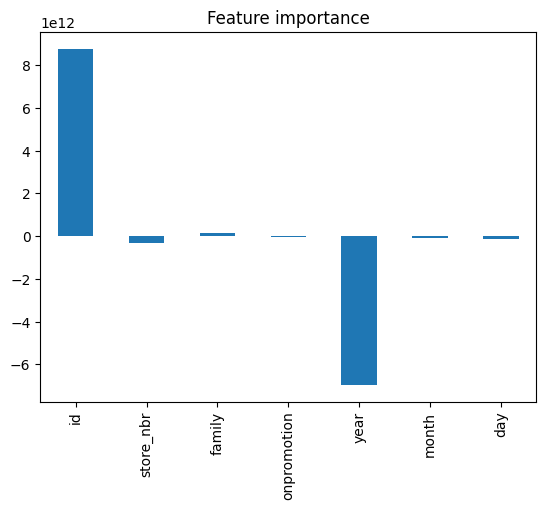

In [32]:
# Plotting the importances
df = pd.DataFrame(imp_dict, index = [0])
df.T.plot.bar(title = "Feature importance", legend = False);

It's obvious that year and id play a huge role in the sales quantity of products